In [1]:
import torch 
import math
import cv2
import numpy as np 
import torch.optim as optim
import matplotlib.pyplot as plt
import timeit 
import torch.nn.functional as F
from tqdm import tqdm
import time
from models import PGGAN, utils, config
from torch import multiprocessing
from degradationOperator import degradeBatch
from style_transfer import transfer
from finetuning import parallelTrain

C:\Users\torre\anaconda3\envs\javier\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\torre\anaconda3\envs\javier\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=> Loading checkpoint


D:\Seismic_denoising_scheme-main\models\utils.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file, map_location="cuda")


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Load poststack data**

torch.Size([1, 1, 128, 128])


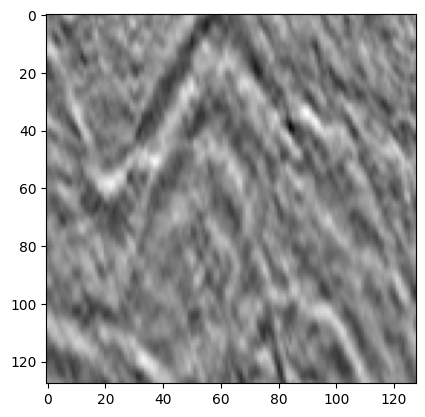

In [3]:
original = cv2.imread('datasets/patch_6314.jpg')

original = original[:,:,0].astype(dtype="float64")

original -= original.min()
original /= original.max()

original = torch.from_numpy(original).unsqueeze(0).unsqueeze(0)

print(original.shape)
plt.imshow(original[0,0,:,:], cmap="gray")
plt.show()

**Import model and load weigths**

In [4]:
from models.Attention_unet import AttU_Net

In [5]:
model = AttU_Net(img_ch=1,output_ch=1).to(device)
model.eval()
model.load_state_dict(torch.load('checkpoints/guided_att_u.pt'))

C:\Users\torre\AppData\Local\Temp\ipykernel_38000\1798962383.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints/guided_att_u.p

<All keys matched successfully>

**EXP III : DOMAIN ADAPTATION**

**Enhancement without domain adaptation**

In [6]:
denoised_patch = model(original.to(device).float())

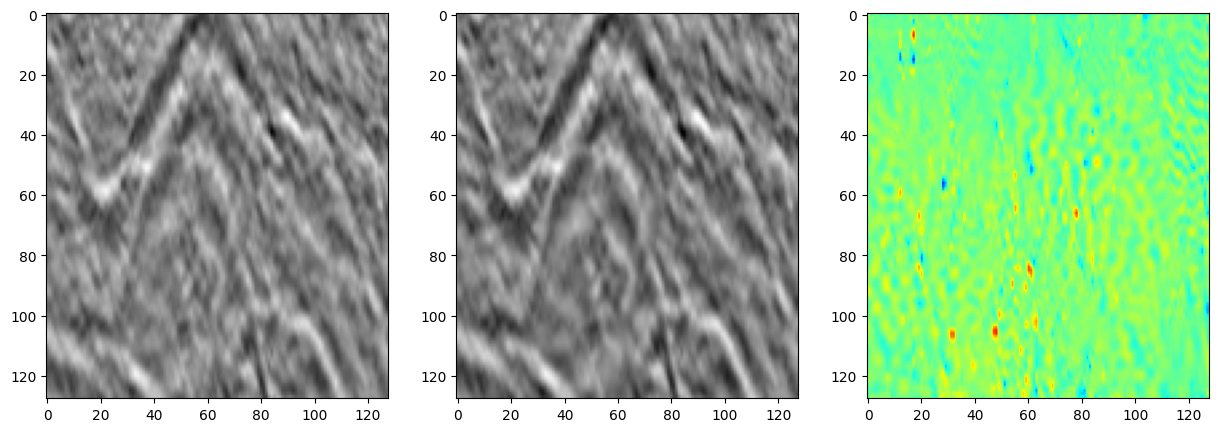

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(original[0,0,:,:], aspect="auto", cmap="gray", vmin=0, vmax=1)
plt.subplot(132)
plt.imshow(denoised_patch[0,0,:,:].detach().cpu().numpy(), aspect="auto", cmap="gray")
plt.subplot(133)
plt.imshow(original[0,0,:,:] - denoised_patch[0,0,:,:].detach().cpu().numpy(), aspect="auto", cmap="jet", vmin=-0.2, vmax=0.2)
plt.show()

**Domain adaptation via neural style transfer**

In [8]:
section = original.squeeze().cpu().numpy()

  0%|                                                                                                                                                                                                      | 0/100 [00:00<?, ?it/s]C:\Users\torre\anaconda3\envs\javier\lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  1%|█▉                                                                                                                                                                                            | 1/100 [00:05<08:55,  5.41s/it]

in


C:\Users\torre\anaconda3\envs\javier\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\torre\anaconda3\envs\javier\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:16<00:00,  4.37s/it]


mean time image degradation:  4.367945055961609
loading time images:  441.17010974884033
damages: torch.Size([100, 5, 128, 128])
0


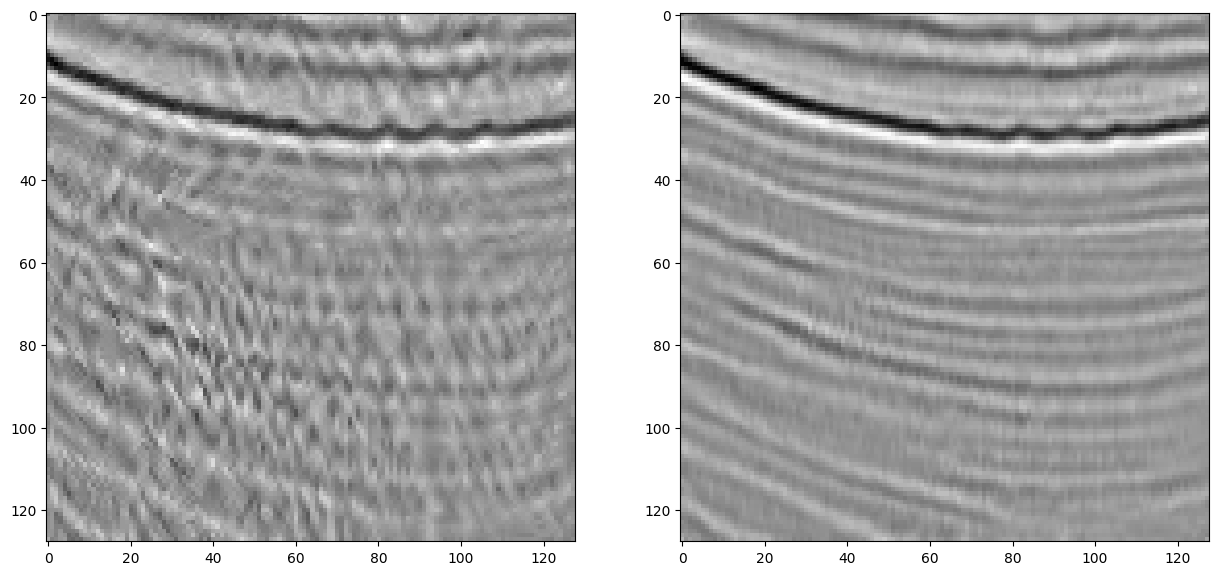

In [9]:
section = section
batch_size=5
epochs=30
iterations=1

gen_samples=100
parallelTrain(section, batch_size, epochs, iterations, gen_samples)

In [10]:
model2 = AttU_Net(img_ch=1,output_ch=1).to(device)
model2.eval()
model2.load_state_dict(torch.load('att_u_fine.pt'))

C:\Users\torre\AppData\Local\Temp\ipykernel_38000\448041754.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('att_u_fine.pt'))


<All keys matched successfully>

In [11]:
denoised_patch2 = model2(original.to(device).float())

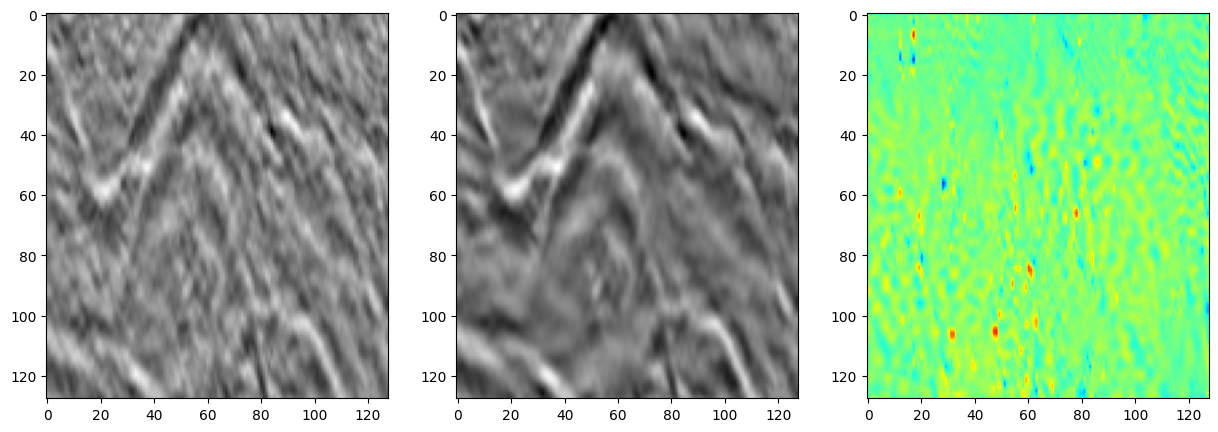

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(original[0,0,:,:], aspect="auto", cmap="gray", vmin=0, vmax=1)
plt.subplot(132)
plt.imshow(denoised_patch2[0,0,:,:].detach().cpu().numpy(), aspect="auto", cmap="gray")
plt.subplot(133)
plt.imshow(original[0,0,:,:] - denoised_patch[0,0,:,:].detach().cpu().numpy(), aspect="auto", cmap="jet", vmin=-0.2, vmax=0.2)
plt.show()